In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Размер изображения: (1920, 1200)
Форма numpy-массива: (1200, 1920, 3)


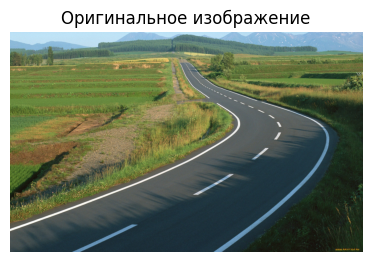

In [39]:
image = Image.open('road.jpg')

image_array = np.array(image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.axis('off')
plt.imshow(image)

print("Размер изображения:", image.size)
print("Форма numpy-массива:", image_array.shape)

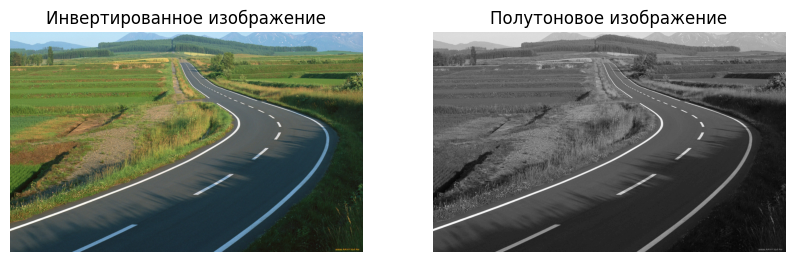

In [40]:
height, width, _ = image_array.shape
gray_image_array = np.zeros((height, width), dtype=np.uint8)

for i in range(height):
    for j in range(width):
        r, g, b = image_array[i, j].astype(np.int16)  # Преобразуем к int16, чтобы избежать переполнения
        gray_image_array[i, j] = (r + g + b) // 3

gray_image_array =  np.clip(gray_image_array, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Инвертированное изображение")
plt.axis('off')
plt.imshow(image_array)

plt.subplot(1, 2, 2)
plt.title("Полутоновое изображение")
plt.imshow(gray_image_array, cmap='gray')
plt.axis('off')
plt.show()


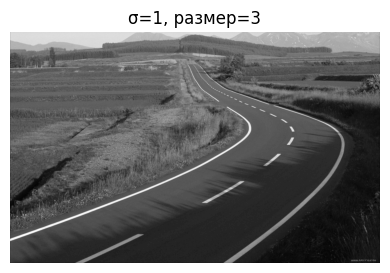

In [41]:
def gaussian_kernel(sigma, size):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / (2 * np.pi * sigma**2)  
    kernel = kernel / np.sum(kernel)  # Нормализуем ядро
    return kernel

def apply_gaussian_blur(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding_y, padding_x = kernel_height // 2, kernel_width // 2

    # Создаем пустой массив для результата
    blurred_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image_height):
        for j in range(image_width):
            sum_value = 0.0 

            for m in range(kernel_height):
                for n in range(kernel_width):
                    # Индексы для области среза
                    x = i + m - padding_y
                    y = j + n - padding_x

                    if 0 <= x < image_height and 0 <= y < image_width:
                        sum_value += image[x, y] * kernel[m, n]

            blurred_image[i, j] = sum_value

    return np.clip(blurred_image, 0, 255).astype(np.uint8)

# Дисперсия <=> Размер ядра
sigma, size = 1, 3

kernel = gaussian_kernel(sigma, size)
blurred_image = apply_gaussian_blur(gray_image_array, kernel)

plt.figure(figsize=(4, 4))
plt.imshow(blurred_image, cmap='gray')
plt.title(f"σ={sigma}, размер={size}")
plt.axis('off')
plt.tight_layout()
plt.show()

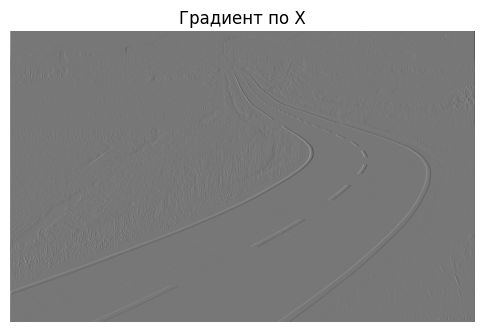

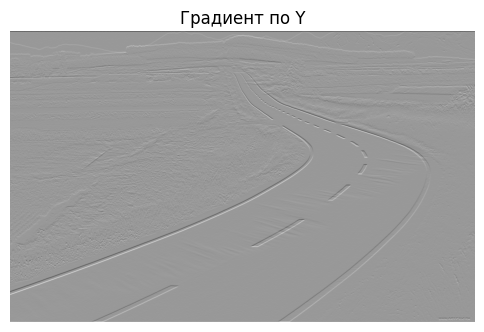

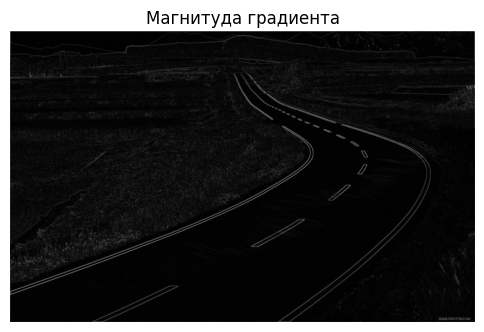

In [42]:
# Фильтры Собеля 3x3
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[ 1,  2,  1], 
                    [ 0,  0,  0], 
                    [-1, -2, -1]])

def apply_filter(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding_y, padding_x = kernel_height // 2, kernel_width // 2

    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image_height):
        for j in range(image_width):
            sum_value = 0.0 

            for m in range(kernel_height):
                for n in range(kernel_width):
                    x = i + m - padding_y
                    y = j + n - padding_x

                    if 0 <= x < image_height and 0 <= y < image_width:
                        sum_value += image[x, y] * kernel[m, n]

            filtered_image[i, j] = sum_value

    return filtered_image

grad_x = apply_filter(blurred_image, sobel_x)
grad_y = apply_filter(blurred_image, sobel_y)

# Магнитуда и направление градиента
gradient_magnitude = np.abs(grad_x) + np.abs(grad_y)
gradient_direction = np.arctan2(grad_y, grad_x)

plt.figure(figsize=(6, 8))
plt.imshow(grad_x, cmap='gray')
plt.title('Градиент по X')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 8))
plt.imshow(grad_y, cmap='gray')
plt.title('Градиент по Y')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 8))
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Магнитуда градиента')
plt.axis('off')
plt.show()


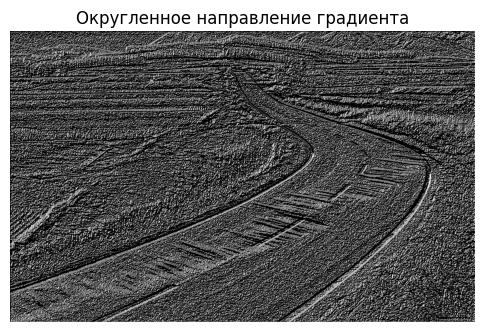

In [43]:
gradient_direction_degrees = np.degrees(gradient_direction)

directions = np.array([0, 45, 90, 135, 180, 225, 270, 315])

def round_to_nearest_direction(angle):
    return directions[np.argmin(np.abs(directions - angle))]

gradient_direction_rounded = np.zeros_like(gradient_direction_degrees)

for i in range(gradient_direction_degrees.shape[0]):
    for j in range(gradient_direction_degrees.shape[1]):
        gradient_direction_rounded[i, j] = round_to_nearest_direction(gradient_direction_degrees[i, j])

plt.figure(figsize=(6, 8))
plt.imshow(gradient_direction_rounded, cmap='gray')
plt.title('Округленное направление градиента')
plt.axis('off')
plt.show()

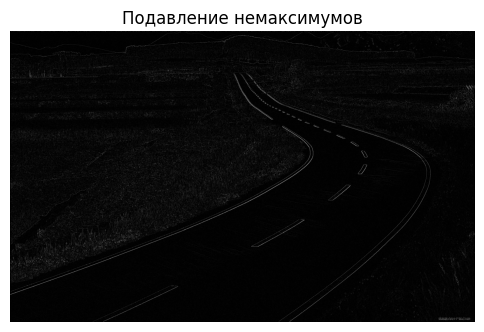

In [44]:
# Подавление немаксимумов
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    image_height, image_width = gradient_magnitude.shape
    suppressed_image = np.zeros((image_height, image_width), dtype=np.float32)

    for i in range(1, image_height-1):
        for j in range(1, image_width-1):

            # Направление градиента для текущего пикселя
            direction = gradient_direction[i, j]

            if direction == 0 or direction == 180:
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
                
            elif direction == 45 or direction == 225:
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]

            elif direction == 90 or direction == 270:
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]

            elif direction == 135 or direction == 315:
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed_image[i, j] = gradient_magnitude[i, j]
            else:
                suppressed_image[i, j] = 0

    return suppressed_image

suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction_rounded)

plt.figure(figsize=(6, 8))
plt.imshow(suppressed_image, cmap='gray')
plt.title('Подавление немаксимумов')
plt.axis('off')
plt.show()

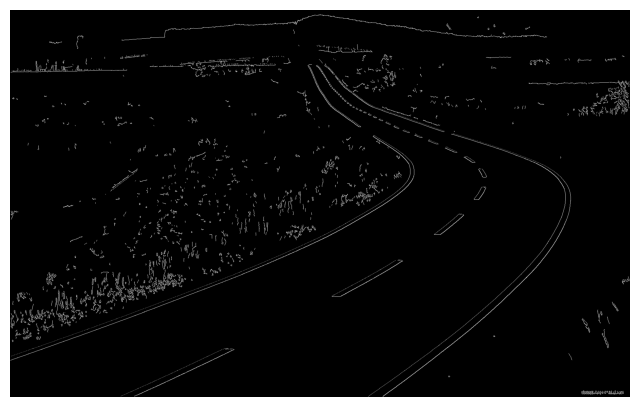

In [45]:
# Гистерезис
def hysteresis_thresholding(suppressed_image, low_threshold, high_threshold):
    image_height, image_width = suppressed_image.shape
    edges = np.zeros((image_height, image_width), dtype=np.uint8)

    # Значения для границ (strong) и пикселей между порогами (weak)
    strong = 255
    weak = 90

    # Границы
    strong_i, strong_j = np.where(suppressed_image > high_threshold)
    
    # Пиксели, которые находятся между порогами
    boundary_i, boundary_j = np.where((suppressed_image >= low_threshold) & (suppressed_image <= high_threshold))

    # Границы на изображении
    edges[strong_i, strong_j] = strong

    # Пиксели между порогами
    edges[boundary_i, boundary_j] = weak

    def grow_edges(x, y):
        stack = [(x, y)]
        
        while stack:
            cx, cy = stack.pop()
            
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    nx, ny = cx + dx, cy + dy
                    
                    if nx < 0 or nx >= image_height or ny < 0 or ny >= image_width:
                        continue
                    
                    if suppressed_image[nx, ny] >= low_threshold and edges[nx, ny] != strong:
                        edges[nx, ny] = strong
                        stack.append((nx, ny))

    for i in range(image_height):
        for j in range(image_width):
            if edges[i, j] == strong:
                grow_edges(i, j)

    # Обнуление пикселей, которые не являются границами (формирование фона)
    edges[edges != strong] = 0

    return edges

# Применяем гистерезис (Уменьшение значений => четкость границ) # 80 160
low_threshold = 100
high_threshold = 200
edges = hysteresis_thresholding(suppressed_image, low_threshold, high_threshold)

# Отображаем результат
plt.figure(figsize=(8, 8))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()


(2264, 270)


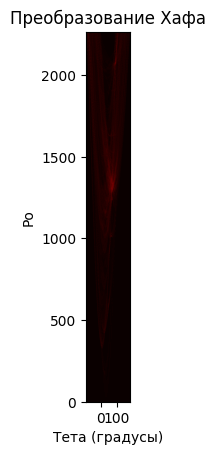

In [46]:
def hough_transform(edges):
    
    height, width = edges.shape
    
    # Диапазон значений theta
    theta_min = -np.pi / 2
    theta_max = np.pi
    theta_step = np.pi / 180 
    thetas = np.arange(theta_min, theta_max, theta_step)
    
    # Диапазон значений ro
    diag_len = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(0, diag_len, 1)
    
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=int)
    
    for y in range(height):
        for x in range(width):
            if edges[y, x] == 255:  
                # Индекс - значение
                for theta_index, theta in enumerate(thetas):
                    ro = int(x * np.cos(theta) + y * np.sin(theta))
                    if 0 <= ro < diag_len:
                        ro_index = ro
                        accumulator[ro_index, theta_index] += 1
    
    return accumulator, thetas, rhos


accumulator, thetas, rhos = hough_transform(edges)
print(accumulator.shape)

plt.imshow(accumulator, cmap='hot', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[0], rhos[-1]])
plt.title('Преобразование Хафа')
plt.xlabel('Тета (градусы)')
plt.ylabel('Ро')
plt.show()

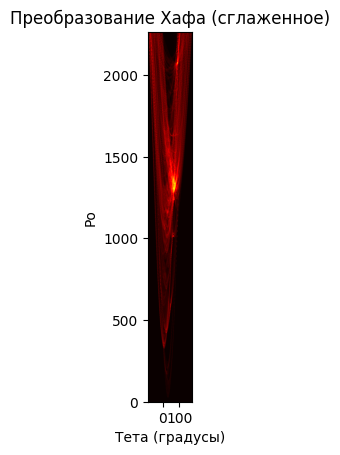

In [47]:
sigma, size = 1, 3
kernel = gaussian_kernel(sigma, size)
smoothed_accumulator = apply_gaussian_blur(accumulator, kernel)

plt.imshow(smoothed_accumulator, cmap='hot', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[0], rhos[-1]])
plt.title('Преобразование Хафа (сглаженное)')
plt.xlabel('Тета (градусы)')
plt.ylabel('Ро')
plt.show()

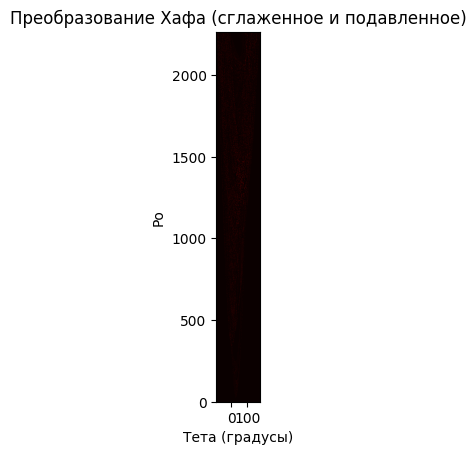

In [48]:
def non_maximum_suppression_haff(accumulator):
    image_height, image_width = accumulator.shape
    suppressed_image = np.zeros((image_height, image_width), dtype=np.float32)

    for i in range(1, image_height-1):
        for j in range(1, image_width-1):

            current_value = accumulator[i, j]
            
            neighbors = [
                accumulator[i-1, j-1], accumulator[i-1, j], accumulator[i-1, j+1],
                accumulator[i, j-1],                     accumulator[i, j+1],
                accumulator[i+1, j-1], accumulator[i+1, j], accumulator[i+1, j+1]
            ]
            
            if current_value >= max(neighbors):
                suppressed_image[i, j] = current_value
            else:
                suppressed_image[i, j] = 0

    return suppressed_image


suppressed_accumulator = non_maximum_suppression_haff(smoothed_accumulator)

plt.imshow(suppressed_accumulator, cmap='hot', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[0], rhos[-1]])
plt.title('Преобразование Хафа (сглаженное и подавленное)')
plt.xlabel('Тета (градусы)')
plt.ylabel('Ро')
plt.show()

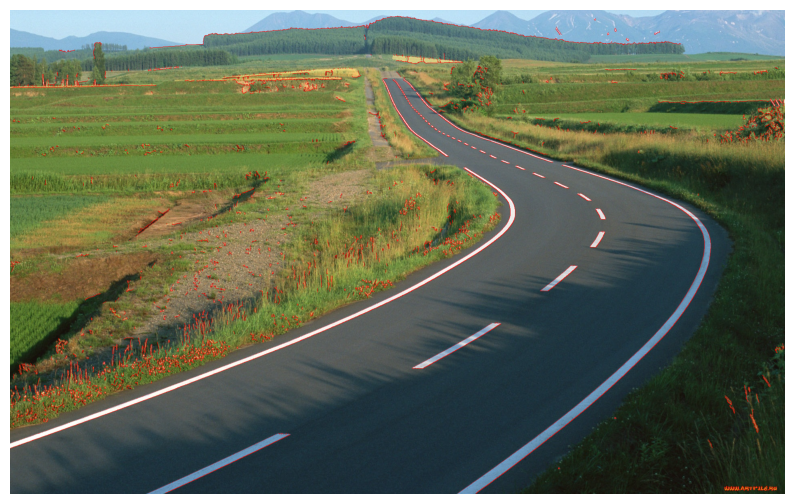

In [ ]:
# def draw_lines(image, accumulator, thetas, rhos):
#     image_with_lines = image.copy()
    
#     # Порог для локальных максимумов
#     # Берем наибольшее количество пересечения синусоид в фазовом пространстве 
#     # Берем 20% от максимального значения
#     threshold = 0.2 * np.max(accumulator)
#     local_max = accumulator > threshold
#     indices = np.argwhere(local_max)
    
#     height, width = image.shape[:2]
    
#     for idx in indices:
#         ro_index, theta_index = idx
#         ro = rhos[ro_index]
#         theta = thetas[theta_index]
        
#         # Для вертикальных линий
#         #  ρ = xcos(θ) + ysin(θ)
#         if abs(np.sin(theta)) < 1e-10:
#             x = int(ro / np.cos(theta))
#             if 0 <= x < width:
#                 image_with_lines[:, x] = [0, 255, 0]
#         else:
#             # При x = 0 => ρ = ysin(θ) => y = ρ/sin(θ)
#             y0 = int(ro / np.sin(theta))
#             # При x = width => ρ = width*cos(θ) + ysin(θ) => ysin(θ) = ρ - width*cos(θ) => y = (ρ - width*cos(θ))/sin(θ)
#             y1 = int((-width * np.cos(theta) + ro) / np.sin(theta))
            
#             # Проверка на пределы изображения(по высоте)
#             if 0 <= y0 < height or 0 <= y1 < height:
#                 x = np.arange(width)
#                 # ρ = xcos(θ) + ysin(θ) => y = (ρ - xcos(θ))/sin(θ)
#                 y = ((ro - x * np.cos(theta)) / np.sin(theta)).astype(int)
                
#                 mask = (y >= 0) & (y < height)
#                 # Синхронная фильтрация
#                 x, y = x[mask], y[mask]
                
#                 # Рисуем линию
#                 image_with_lines[y, x] = [0, 255, 0]
    
#     return image_with_lines

# # Использование
# image_with_lines = draw_lines(image_array, accumulator, thetas, rhos)

# plt.figure(figsize=(10, 10))
# plt.imshow(image_with_lines)
# plt.axis('off')
# plt.show()

# Код для отрисовки только тех линий, которые принадлежат границам.


def draw_lines_on_image(original_image, suppressed_hough, theta_range, rho_range, edge_image):

    line_image = np.copy(original_image)  
    height, width = line_image.shape[:2]  

    tresh = 0.5 *np.max(suppressed_hough)
    indices = np.argwhere(suppressed_hough > 0)

    for rho_idx, theta_idx in indices:
        rho = rho_range[rho_idx]
        theta = theta_range[theta_idx]

        x = np.arange(0, width)
        y = ((rho - x * np.cos(theta)) / np.sin(theta)).astype(int)

        for px, py in zip(x, y):
            if 0 <= px < width and 0 <= py < height:  
                try:
                    
                    if edge_image[py, px] == 255:  
                        line_image[py, px] = [255, 0, 0]  
                    
                except IndexError:
                    print(f"Индекс вне границ: px={px}, py={py}, width={width}, height={height}")
                    continue

    return line_image


# Использование
image_with_lines = draw_lines_on_image(image_array, accumulator, thetas, rhos, edges)

plt.figure(figsize=(10, 10))
plt.imshow(image_with_lines)
plt.axis('off')
plt.show()
